In [6]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env_v2.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome


In [7]:
def get_robot(genome, robot_size, neat_config, env_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, env_config=env_config)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [8]:
with open(f"../checkpoints/cp_3d_5_mult_out_1_100.pkl", "rb") as file:
    poet_pop = pkl.load(file)
    
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, poet_pop.run_params.robot_size)
CustomGenome.substrate = morph_substrate(poet_pop.run_params.robot_size, poet_pop.run_params.substrate_type)
CustomGenome.robot_size = poet_pop.run_params.robot_size
CustomGenome.spec_genotype_weight = poet_pop.run_params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = poet_pop.run_params.spec_phenotype_weight

In [9]:
def show_img(ag, min_fit, robot_size, neat_config, env_config):
    if ag.fitness is not None and ag.fitness > min_fit:
        r, img = get_robot(ag, robot_size, neat_config, env_config)
        if img is not None:
            print(ag.key, ag.fitness)
            plt.imshow(img)
            plt.show()
            cppn = neat.nn.FeedForwardNetwork.create(ag, neat_config)
            
            design_substrate = morph_substrate(robot_size, "3d")
            controller_substrate = control_substrate(robot_size, "dynamic", ag.robot, "3d")


            
            design_net = create_phenotype_network(cppn, design_substrate, output_node_idx=0)
            controller_net = create_phenotype_network(cppn, controller_substrate, output_node_idx=1)

            print("CPPN")
            display(draw_net(cppn))
            # print("Controller:")
            # display(draw_net(controller_net))
            # print("Morphology:")
            # display(draw_net(design_net))




###################### Pair (env: 0, pop: 0) ########################

------------- Champion ----------------
1157 4.496703674086467


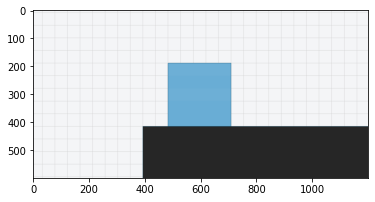

CPPN


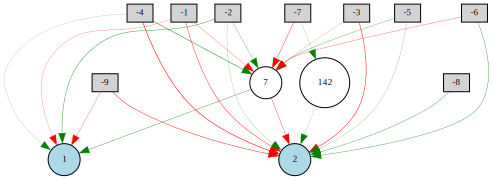



###################### Pair (env: 12, pop: 12) ########################

------------- Champion ----------------
999 2.8520055512449853


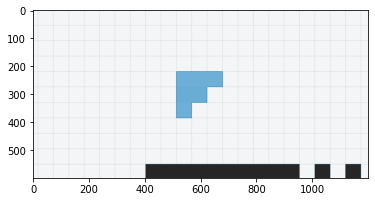

CPPN


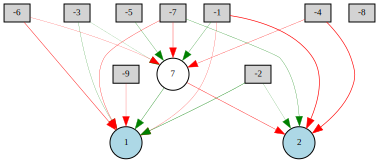



###################### Pair (env: 10, pop: 10) ########################

------------- Champion ----------------
1257 2.933460562808816


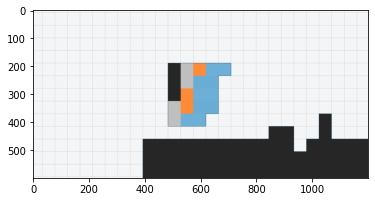

CPPN


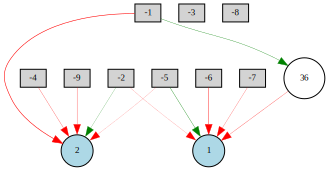



###################### Pair (env: 14, pop: 14) ########################

------------- Champion ----------------
1068 4.204686682344489


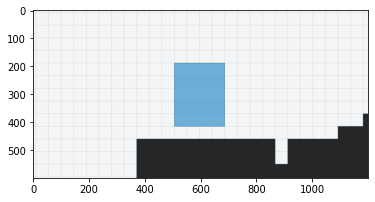

CPPN


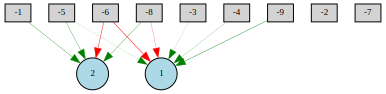



###################### Pair (env: 36, pop: 82) ########################

------------- Champion ----------------
223 3.7249182365497964


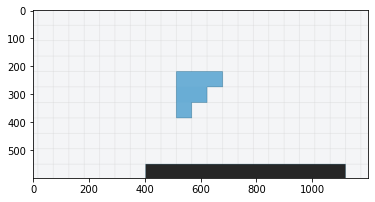

CPPN


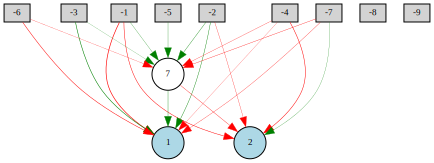



###################### Pair (env: 34, pop: 73) ########################

------------- Champion ----------------
309 7.481006653731279


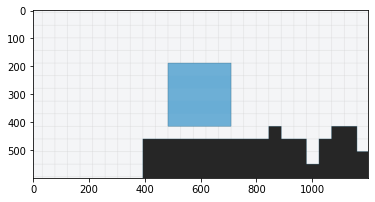

CPPN


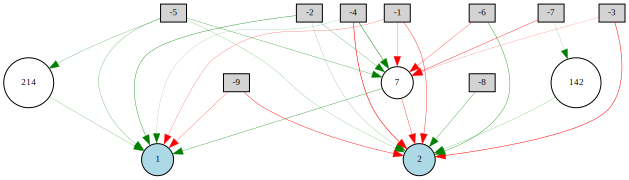



###################### Pair (env: 29, pop: 56) ########################

------------- Champion ----------------
321 4.165309787038935


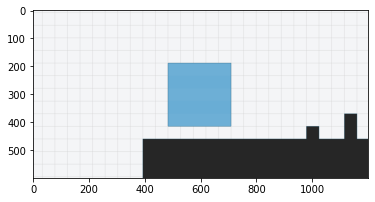

CPPN


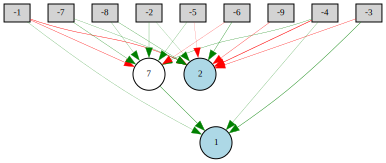

In [10]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair (env: {env.id}, pop: {pop.id}) ########################\n")
    
    # for ag_id, ag in pop.pop.population.items():
    #     show_img(ag, 1.5, pop.robot_size, pop.neat_config, env)
    
    print("------------- Champion ----------------")
    show_img(pop.pop.best_genome, -1, pop.robot_size, pop.neat_config, env)


In [11]:
STEPS = 400
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [12]:
def show_exec(ag_id, env_id):
    ag, pop = ag_dict[ag_id]
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", env_dict[env_id], True, None)
    return reward, done

In [ ]:
r, d = show_exec(1257, 0)
print(r)

In [9]:
env_id = 98
env1 = poet_pop.mutate(env_dict[env_id])
env2 = poet_pop.mutate(env_dict[env_id])

print(env_dict[env_id].obstacle_prob)
print(env1.obstacle_prob, env2.obstacle_prob)

KeyError: 98

In [ ]:
# poet_pop.create_environments()